In [61]:
import pandas as pd
import numpy as np
import os
import re
import json

import calendar

import nltk
from nltk.tokenize import word_tokenize
import spacy
import re
import collections
import string
from wordcloud import WordCloud

from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def read_jl_file(file_name):
    values = []
    with open(file_name, 'rb') as f:
        line = '---'
        while len(line)>1:
            line = f.readline()
            values.append(line)
    values = values[:-1]
    values = [json.loads(i) for i in values]
    df = pd.DataFrame(values)
    df_restos = df[df['resto_url'].notnull()]
    df_reviews = df[df['review_url'].notnull()]

    # check that there are no duplicates
    assert (df_restos.shape[0] == df_restos.drop_duplicates('resto_url').shape[0])
    assert (df_reviews.shape[0] == df_reviews.drop_duplicates('review_url').shape[0])

    return df_restos.dropna(axis=1, how='all').reset_index(drop=True), df_reviews.dropna(axis=1, how='all').reset_index(drop=True)

restos, reviews = read_jl_file(os.path.join('scrapped_data', 'scrapped_data.jl'))

# Process restaurants

In [48]:
def process_restaurant_data(df):
    df = df.copy()
    df.loc[:, 'resto_name'] = [name[0] for name in df.loc[:, 'resto_name']]

    # extract research ID
    df.loc[:, 'research_id'] = [re.findall(r'\-g(\d+)\-', url) for url in df.loc[:, 'resto_url']]
    df.loc[:, 'resto_id'] = [re.findall(r'\-d(\d+)\-', url) for url in df.loc[:, 'resto_url']]
    
    # extract rating
    pattern = r'([0-9]\.[0-9])\s'
    df.loc[:, 'resto_rating'] = [float(
        re.findall(pattern, rating[0])[0]) for rating in df.loc[:, 'resto_rating']]
    
    # extract additional information
    col_details = ['Meals', 'PRICE RANGE', 'CUISINES', 'Special Diets', 'FEATURES']
    for col in col_details:
        df.loc[:, col] = np.nan

    df.reset_index(drop=True, inplace=True)
    for idx in df.index:
        keys = df.iloc[idx, :]['resto_keys']
        values = df.iloc[idx, :]['resto_details']
        for k, v in zip(keys, values):
            df.loc[:, k][idx] = v
            
    df.columns = [col.lower() for col in df.columns]
    
    return df.drop(columns=['resto_keys', 'resto_details'])

In [49]:
clean_restaurants = process_restaurant_data(restos)

In [50]:
clean_restaurants.head(2)

,resto_url,resto_name,resto_rating,research_id,resto_id,meals,price range,cuisines,special diets,features
0,https://www.tripadvisor.co.uk/Restaurant_Revie...,Mezzet Dar,5.0,504169,7221903,NaN,NaN,NaN,NaN,NaN
1,https://www.tripadvisor.co.uk/Restaurant_Revie...,4 Locos Argentine Steakhouse,5.0,2536732,14976947,"Lunch, Dinner, Brunch, Drinks",NaN,"Steakhouse, Argentinian","Vegetarian Friendly, Gluten Free Options",NaN


# Process reviews

In [249]:
def preprocess_reviews(df):
    df = df.copy()
    df.loc[:, 'resto_name'] = [name[0] for name in df.loc[:, 'resto_name']]
    df.loc[:, 'review_rating'] = [rating[-2] for rating in df.loc[:, 'review_rating']]
    df.loc[:, 'review_likes'] = [0 if like is None else like for like in df.loc[:, 'review_likes']]
    df.loc[:, 'user_number_likes'] =  df.loc[:, 'user_number_likes'].fillna(0)
    df.loc[:, 'research_id'] = [re.findall(r'\-g(\d+)\-', url) for url in df.loc[:, 'review_url']]
    df.loc[:, 'resto_id'] = [re.findall(r'\-d(\d+)\-', url) for url in df.loc[:, 'review_url']]
    df.loc[:, 'review_id'] = [re.findall(r'\-r(\d+)\-', url) for url in df.loc[:, 'review_url']]

    # convert review dates to datetime objects
    months = {month: str(index) for index, month in enumerate(calendar.month_name) if month}
    df.loc[:, 'review_month'] = [d.strip().split(' ')[0] if d is not None else d for d in df.loc[:, 'review_date']]
    df.loc[:, 'review_month'] = df.loc[:, 'review_month'].replace(months)
    df.loc[:, 'review_year'] = [d.strip().split(' ')[1] if d is not None else d for d in df.loc[:, 'review_date']]

    df.loc[:, 'clean_date'] = df.loc[:, 'review_month'] + '-01-' + df.loc[:, 'review_year']
    df.loc[:, 'clean_date'] = pd.to_datetime(df.loc[:, 'clean_date'])
    df.drop(columns=['review_year', 'review_month'], inplace=True)

    df.loc[:, 'review_length'] = [len(review) for review in df.loc[:, 'review_content']]
    
    return df

In [250]:
clean_reviews = preprocess_reviews(reviews)

In [251]:
clean_reviews.head(2)

,resto_name,review_url,review_title,review_content,review_date,review_rating,review_likes,user_number_reviews,user_number_likes,research_id,resto_id,review_id,clean_date,review_length
0,Mezzet Dar,https://www.tripadvisor.co.uk/ShowUserReviews-...,Fabulous lunch at Dar,Booked at Mezzet Dar not realising there are t...,December 2019,5,0,13,5,504169,7221903,735106834,2019-12-01,136
1,Awesome Thai #Barnes,https://www.tripadvisor.co.uk/ShowUserReviews-...,Out of lockdown into excellent Thai food,Awesome Thai worked hard during lockdown to de...,July 2020,5,1,13,8,186338,3490463,759914900,2020-07-01,843


# Visualization

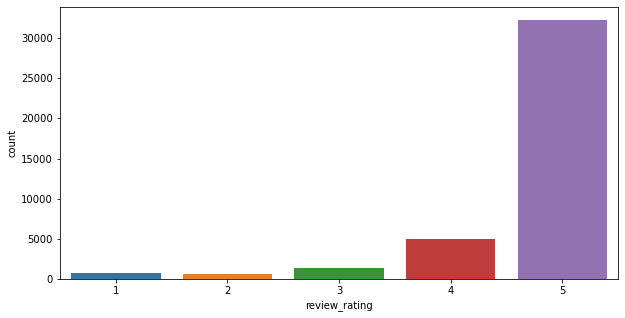

In [252]:
plt.figure(figsize=(10, 5))
sns.countplot(x='review_rating', data=clean_reviews)
plt.show()

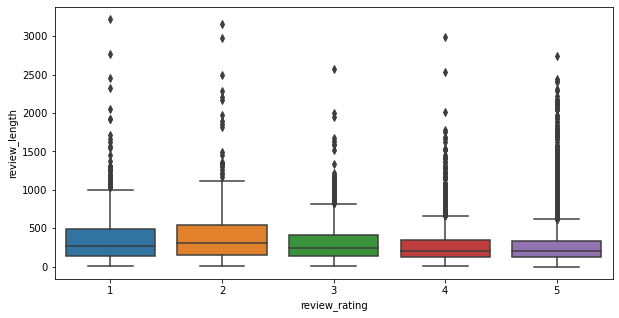

In [253]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='review_rating', y='review_length', data=clean_reviews)
plt.show()

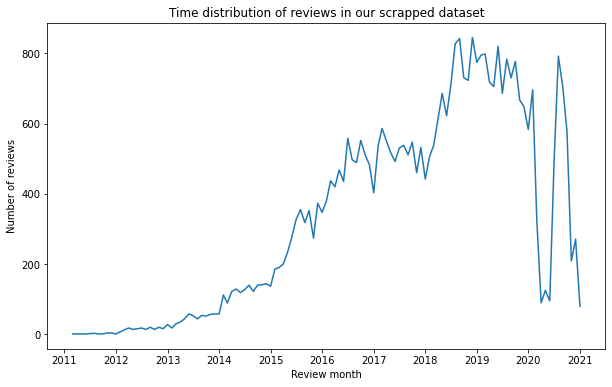

In [160]:
reviews_by_date = clean_reviews['clean_date'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=reviews_by_date.index, y=reviews_by_date.values)
plt.title('Time distribution of reviews in our scrapped dataset')
plt.xlabel('Review month')
plt.ylabel('Number of reviews')
plt.show()

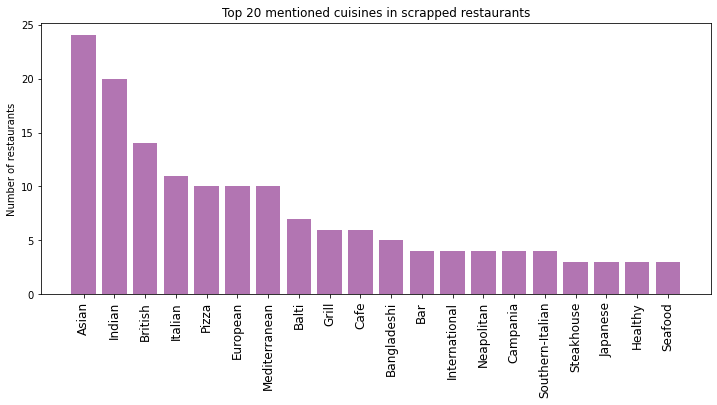

In [239]:
# Get count of cuisine mentions
from collections import Counter, OrderedDict
cuisines = ",".join(cuisine for cuisine in clean_restaurants['cuisines'].dropna())
cuisines = Counter([cuisine.strip() for cuisine in cuisines.split(',')])
cuisines_ordered = OrderedDict(cuisines.most_common())

# Plot number of mentions per cuisine
y_pos = np.arange(len(list(cuisines_ordered.keys())[:20]))
plt.figure(figsize=(12, 5))
plt.bar(y_pos, list(cuisines_ordered.values())[:20], color = (0.5,0.1,0.5,0.6))
plt.xticks(y_pos, list(cuisines_ordered.keys())[:20], rotation=90, fontsize=12)
plt.ylabel('Number of restaurants')
plt.title('Top 20 mentioned cuisines in scrapped restaurants')
plt.show()

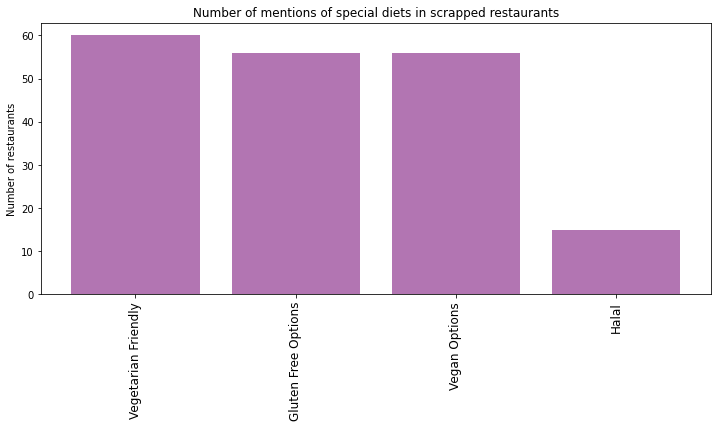

In [246]:
# Get count of regime mentions
from collections import Counter, OrderedDict
regimes = ",".join(regime for regime in clean_restaurants['special diets'].dropna())
regimes = Counter([regime.strip() for regime in regimes.split(',')])
regimes_ordered = OrderedDict(regimes.most_common())

# Plot number of mentions per cuisine
y_pos = np.arange(len(regimes_ordered.keys()))
plt.figure(figsize=(12, 5))
plt.bar(y_pos, regimes_ordered.values(), color = (0.5,0.1,0.5,0.6))
plt.xticks(y_pos, regimes_ordered.keys(), rotation=90, fontsize=12)
plt.ylabel('Number of restaurants')
plt.title('Number of mentions of special diets in scrapped restaurants')
plt.show()

# Preprocess text reviews

In [139]:
corpus = reviews.loc[:, 'review_content']

In [140]:
class PreprocessText:
    
    def __init__(self, raw_text):
        self.text = raw_text
        
    # expand abbreviations
    def decontract_words(self):
        # punctuation mistake 
        phrase = re.sub(r"’", "'", self.text)
        phrase = re.sub(r'\\', "'", self.text)

        # specific
        phrase = re.sub(r"won\'t", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    
    def tokenize_words(self, decontract=True):
        if decontract:
            text = self.decontract_words()
        else:
            text = self.text
            
        tokenized_text = word_tokenize(text)
        return tokenized_text
    
    def preprocess_tokens(self, decontract=True):
        words = self.tokenize_words(decontract)
            
        # create list of punctuation characters
        punctuation = string.punctuation
        customized_punctuation = ['“','”', '...', '', '’']
        for punct in customized_punctuation:
            punctuation += punct
            
        # lower words and remove punctuation
        words = [word.lower().replace('\n', '') for word in words if word not in punctuation]
        words = [word for word in words if len(re.findall(r'\d+', word)) == 0]
        
        return words
    
    def remove_stop_words_tokens(self, keep_stop_words=['most', 'very', 'not'], decontract=True):
        words = self.preprocess_tokens(decontract)
        
        # define stop words
        nltk_stop_words = nltk.corpus.stopwords.words('english')
        for stop_word in keep_stop_words:
            nltk_stop_words.remove(stop_word)
            
        # return text without stop words
        text_without_stop_words = [t for t in words if t not in nltk_stop_words]
        
        return text_without_stop_words
    
    def stemm_tokenized_words(self, keep_stop_words=['most', 'very', 'not'], decontract=True):
        words = self.remove_stop_words_tokens(keep_stop_words, decontract)
        
        # initialize stemmers
        stemmer = PorterStemmer()
        stemmed_words = []
        for word in words:
            stemmed_words.append(stemmer.stem(word))
        
        return stemmed_words

In [141]:
preprocessed_corpus = [PreprocessText(raw_text) for raw_text in corpus]
preprocessed_corpus = [text_item.stemm_tokenized_words() for text_item in preprocessed_corpus]

# TD-IDF matrix

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
vectorizer = TfidfVectorizer()
corpus_matrix = vectorizer.fit_transform(corpus)

In [39]:
corpus_matrix.todense().shape

(39830, 24382)

In [41]:
len(vectorizer.vocabulary_)

24382

# Show wordcloud

In [158]:
def show_wordcloud(corpus, add_stop_words=['also', 'lot'], keep_stop_words=[]):
    """
    Input: corpus as a list of texts
        Add_stop_words: words to display that are not in nltk_stop_words
        Keep_stop_words: words to not display that are in nltk_stop_words
    Output: show a wordcloud for the corpus
    """

    nltk_stop_words = nltk.corpus.stopwords.words('english')
    for stop_word in keep_stop_words:
        nltk_stop_words.remove(stop_word)
    for stop_word in add_stop_words:
        nltk_stop_words.append(stop_word)


    full_corpus = text = " ".join(review for review in corpus)
    wordcloud = WordCloud(
        stopwords=nltk_stop_words, background_color="white").generate(full_corpus)

    plt.figure(figsize=(15, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

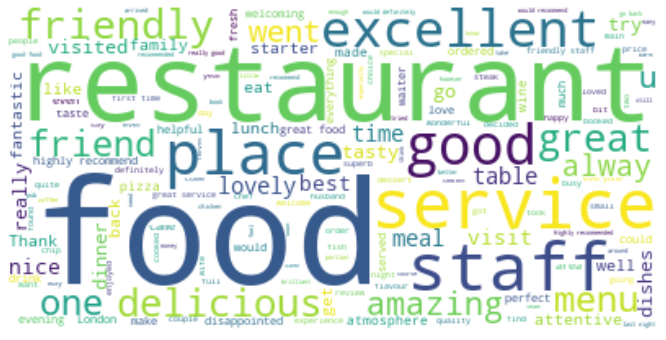

In [254]:
show_wordcloud(corpus)

In [255]:
def show_wordcloud_per_rating(df, rating, add_stop_words=['also', 'lot'], keep_stop_words=[]):
    """
    Input: corpus as a list of texts
        Add_stop_words: words to display that are not in nltk_stop_words
        Keep_stop_words: words to not display that are in nltk_stop_words
    Output: show a wordcloud for the corpus
    """

    filtered_corpus = list(df[df['review_rating'] == rating]['review_content']